# Build a PCA Model for Stock Portfolio Analysis

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 11.8 MB/s 
     |████████████████████████████████| 63 kB 379 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
pip install mpl_axes_aligner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for mpl-axes-aligner: filename=mpl_axes_aligner-1.3-py3-none-any.whl size=4771 sha256=028e7da00e852eb4b6795424cf9c45c2fe454fbea56fef8e1225f15579e3f0ab
  Stored in directory: /root/.cache/pip/wheels/5d/6e/db/27d06190752db6eb59bf8b399cad1702178c0f50d765e41c0a
Successfully built mpl-axes-aligner


In [4]:
## imports ##
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math
import statsmodels.api as sm
import scipy.stats as stats
import mpl_axes_aligner
from typing import Dict,Tuple

In [5]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def biplot(dfScores: pd.DataFrame, dfLoadings: pd.DataFrame) -> None:
    
    #create figure and axis objects
    fig,ax = plt.subplots(figsize=(15,8))
    
    #make a scores plot
    ax.scatter(dfScores.PC1.values,dfScores.PC2.values, color='b')
    #set x-axis label
    ax.set_xlabel("PC1",fontsize=10)
    #set y-axis label
    ax.set_ylabel("PC2",fontsize=10)
    
    #create a second set of axes
    ax2 = ax.twinx().twiny()
    
    #make a loadings plot
    for col in dfLoadings.columns.values:
        #where do our loading vectors end?
        tipx = dfLoadings.loc['PC1',col]
        tipy = dfLoadings.loc['PC2',col]
        #draw the vector, and write label text for col
        ax2.arrow(0, 0, tipx, tipy, color = 'r', alpha = 0.5)
        ax2.text(tipx*1.05, tipy*1.05, col, color = 'g', ha = 'center', va = 'center')
    
    #align x = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.xaxes(ax, 0, ax2, 0, 0.5)
    #align y = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.yaxes(ax, 0, ax2, 0, 0.5)
    
    #show plot
    plt.show()
    
#Function to check  whether the point (x,y) is outside the ellipse defined by (u,v,a,b)
def outside_ellipse(x, y, u, v, a, b):
 
    #checking the equation of ellipse with the given point
    p = ((x-u)/a)**2 + ((y-v)/b)**2 
        
    #convert output to boolean (True if outside the ellipse)
    p = p > 1

    return(p)

In [7]:
stocks = "AAPL MSFT AMZN FB GOOG NVDA FIS AMD TDC HUBS FTNT ASML INTC IBM ORCL CSCO " \
         "SONY HTHIY TCEHY PCRFY LNVGY"
dfData = yf.download(stocks, start="2010-01-01", end="2015-10-01")

[*********************100%***********************]  21 of 21 completed


In [8]:
dfData_new = pd.read_csv('/content/drive/My Drive/sirius/PCA/sp100.csv')

In [9]:
dfData_new.head()

,Unnamed: 0,AAPL,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AXP,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
0,2007-05-01,-0.003312,0.006864,-0.001792,0.004082,0.001715,0.014856,0.000000,0.011510,0.010657,...,0.013582,-0.005860,-0.017927,-0.006982,0.001164,0.008606,0.007489,0.004170,0.008520,0.003521
1,2007-05-02,0.009206,0.003153,-0.001795,-0.005286,0.005554,-0.000461,0.016961,-0.013959,0.022893,...,0.007720,0.019524,0.010636,0.011374,0.003194,0.027911,0.007882,-0.001959,-0.001035,0.002006
2,2007-05-03,0.000100,0.003839,0.007416,-0.007496,0.003261,-0.017988,-0.013283,0.016374,0.011411,...,-0.000570,-0.011217,0.027223,0.002118,-0.004357,0.036449,-0.000673,0.004194,0.001656,0.010716
3,2007-05-04,0.004076,0.015384,-0.003829,0.003150,0.002827,-0.002664,0.007054,0.016585,-0.001104,...,0.001993,0.007119,0.000772,0.002817,0.004067,-0.010033,0.006042,0.002229,-0.001862,-0.001612
4,2007-05-07,0.030384,0.011088,-0.020672,-0.000484,0.010530,0.000314,0.015244,-0.038860,-0.001895,...,0.001137,-0.005991,-0.001716,-0.004370,0.003762,0.004172,0.005119,0.004167,0.007019,0.003470


In [10]:
missing_values = ((dfData_new.isna().sum() / len(dfData_new)) * 100).sort_values()
print('Процент пропущенных значений:')
missing_values

Процент пропущенных значений:


Unnamed: 0    0.0
NKE           0.0
NFLX          0.0
NEE           0.0
MSFT          0.0
             ... 
CVX           0.0
CVS           0.0
CSCO          0.0
COST          0.0
XOM           0.0
Length: 90, dtype: float64

In [11]:
dfData_new = dfData_new.drop(columns=['Unnamed: 0'])

In [12]:
dfData_new.head()

,AAPL,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AXP,BA,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
0,-0.003312,0.006864,-0.001792,0.004082,0.001715,0.014856,0.000000,0.011510,0.010657,0.002470,...,0.013582,-0.005860,-0.017927,-0.006982,0.001164,0.008606,0.007489,0.004170,0.008520,0.003521
1,0.009206,0.003153,-0.001795,-0.005286,0.005554,-0.000461,0.016961,-0.013959,0.022893,0.006415,...,0.007720,0.019524,0.010636,0.011374,0.003194,0.027911,0.007882,-0.001959,-0.001035,0.002006
2,0.000100,0.003839,0.007416,-0.007496,0.003261,-0.017988,-0.013283,0.016374,0.011411,0.000213,...,-0.000570,-0.011217,0.027223,0.002118,-0.004357,0.036449,-0.000673,0.004194,0.001656,0.010716
3,0.004076,0.015384,-0.003829,0.003150,0.002827,-0.002664,0.007054,0.016585,-0.001104,-0.002561,...,0.001993,0.007119,0.000772,0.002817,0.004067,-0.010033,0.006042,0.002229,-0.001862,-0.001612
4,0.030384,0.011088,-0.020672,-0.000484,0.010530,0.000314,0.015244,-0.038860,-0.001895,0.010098,...,0.001137,-0.005991,-0.001716,-0.004370,0.003762,0.004172,0.005119,0.004167,0.007019,0.003470


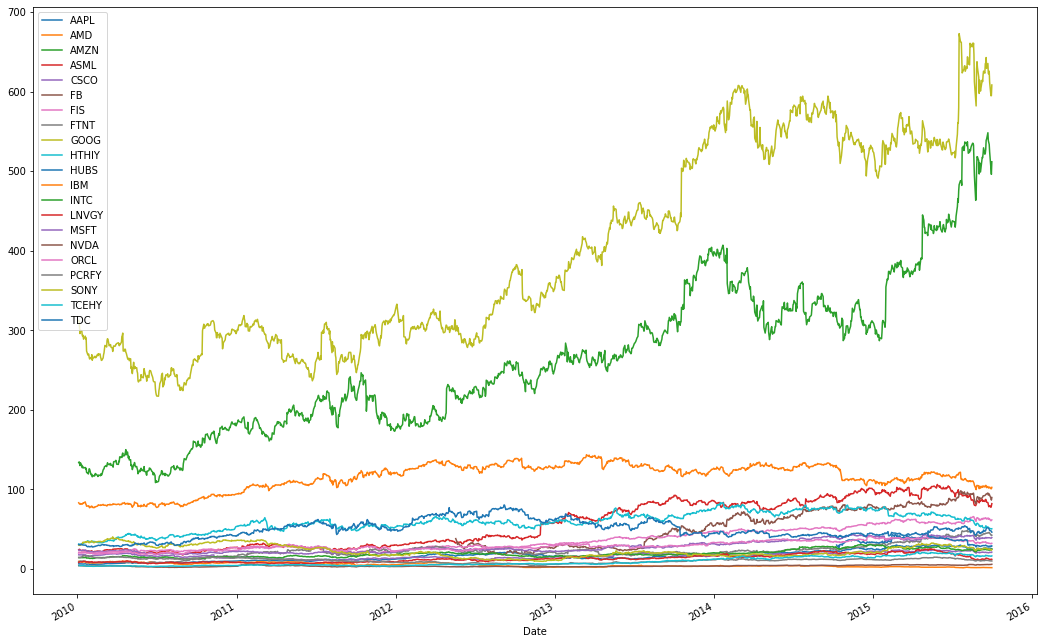

In [13]:
#extract out adjusted close prices
dfClose = dfData['Adj Close'].copy()

#plot the adjusted close prices
dfClose.plot(figsize=(18,12))
plt.show()

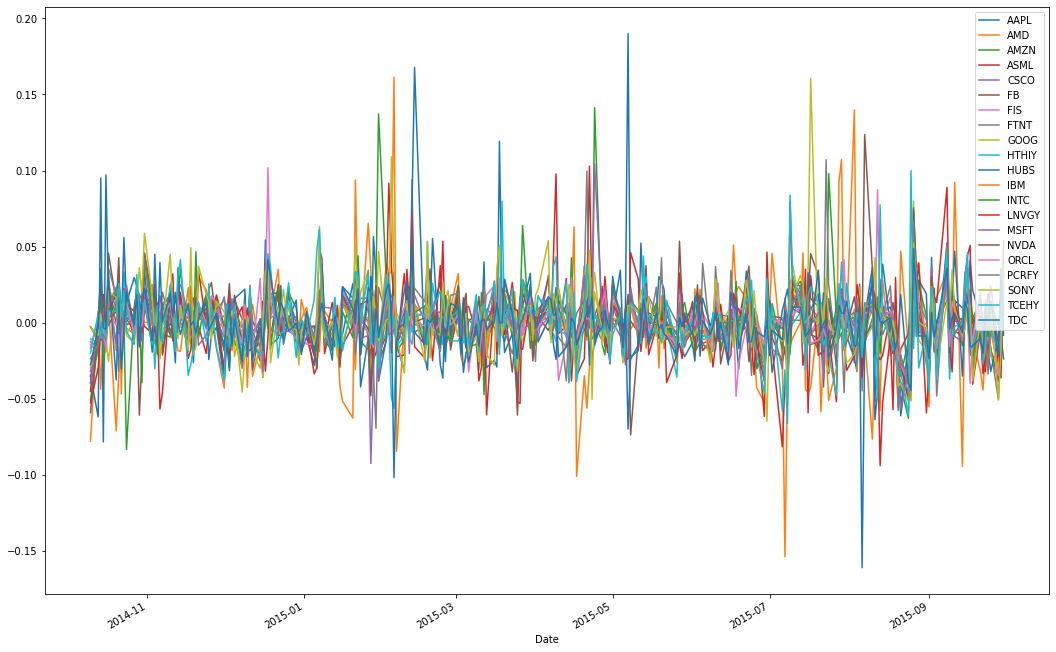

In [14]:
#compute differences in close prices
dfClose = dfClose.pct_change().dropna()

#plot the differenced close prices
dfClose.plot(figsize=(18,12))
plt.show()

In [15]:
scaler = StandardScaler()
closes = scaler.fit_transform(dfClose)
dfClose = pd.DataFrame(closes,columns=dfClose.columns)

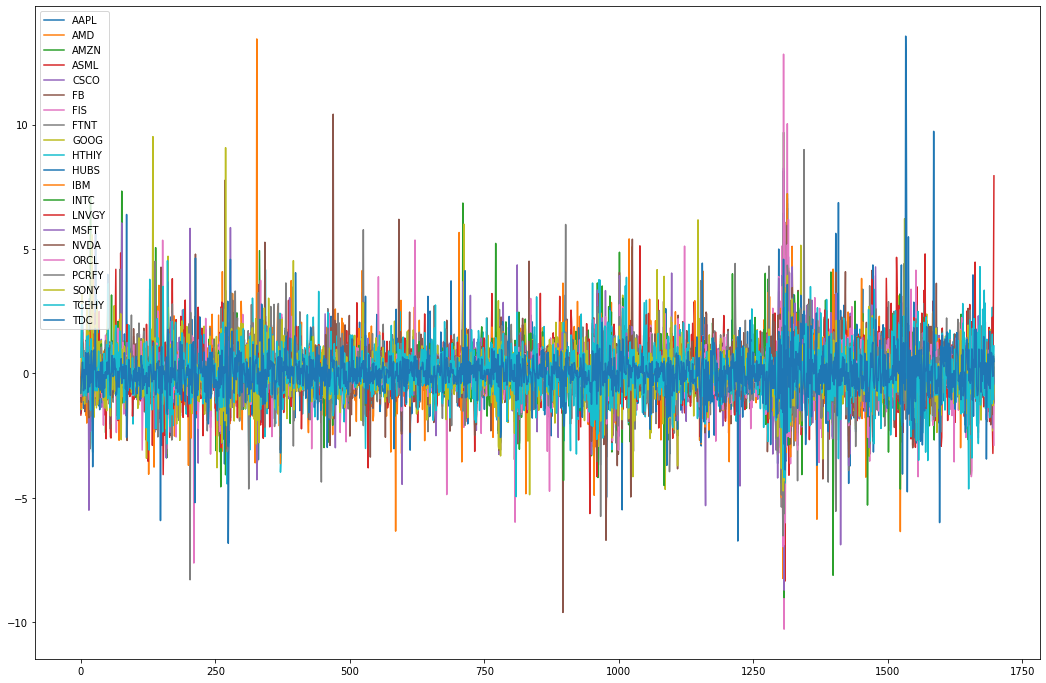

In [ ]:
#plot the standardised close price differences
dfClose.plot(figsize=(18,12))
plt.show()

## PCA - Training

In [16]:
class PCA(object):
    #initialiser function
    def __init__(self,n_components : int = 0) -> None:
        self.n_components = n_components
        self.e_val        = np.array([])
        self.e_vec        = np.array([])
        self.col_idx      = np.array([])
        
    #destructor
    def __del__(self) -> None:
        del self.n_components
        del self.e_val
        del self.e_vec
        del self.col_idx

    def fit(self, X_train : np.array) -> None:
        #since I'm assuming the input matrix X_train has shape (samples,features), compute the transpose
        X = np.transpose(X_train)
        #remove the mean from each feature
        X -= np.mean(X,axis=1).reshape(-1,1)
        #compute the covariance matrix of X
        C = np.matmul(X,np.transpose(X))
        #find the eigenvalues & eigenvectors of the covariance
        self.e_val,self.e_vec = np.linalg.eig(C)
        #sort the negated eigenvalues (to get sort in decending order)
        self.col_idx = np.argsort(-self.e_val)

        #public function to transform the dataset
    def transform(self, X) -> np.array:
        #check that the model has been trained?
        if self.e_val.size and self.e_vec.size and self.col_idx.size:
            #since I'm assuming the input matrix X_train has shape (samples,features), compute the transpose
            X = np.transpose(X)
            #project data onto the PCs
            X_new = np.matmul(np.transpose(self.e_vec),X)
            #transform back via tranpose + sort by variance explained
            X_new = np.transpose(X_new)
            X_new = X_new[:,self.col_idx]
            #if n_components was specified, return only this number of features back
            if self.n_components != 0:
                X_new = X_new[:,:self.n_components]
            #return
            return(X_new)
        else:
            print('Empty eigenvectors and eigenvalues, did you forget to train the model?')
            return(np.array([]))

         #public function to return % explained variance per PC
    def explained_variance_ratio(self) -> np.array:
        #check that the model has been trained?
        if self.e_val.size and self.col_idx.size:
            #compute the sorted % explained variances 
            perc = self.e_val[self.col_idx]
            perc = perc/np.sum(perc)
            #if n_components was specified, return only this number of features back
            if self.n_components != 0:
                perc = perc[:self.n_components]
            #return
            return(perc)
        else:
            print('Empty eigenvalues, did you forget to train the model?')
            return(np.array([]))


    #public function to return the eigenvalues & eigenvectors
    def return_eigen_vectors_values(self) -> Tuple[np.array,np.array]:
        #check that the model has been trained?
        if self.e_val.size and self.e_vec.size and self.col_idx.size:
            #sort the eigenvalues and eigenvectors
            e_val = self.e_val[self.col_idx]
            e_vec = self.e_vec[:,self.col_idx]
            #if n_components was specified, return only this number of features back
            if self.n_components != 0:
                e_val = e_val[:self.n_components]
                e_vec = e_vec[:,:self.n_components]
            #return
            return(e_vec,e_val)
        else:
            print('Empty eigenvalues & eigenvectors, did you forget to train the model?')
            return(np.array([]),np.array([]))

In [17]:
pca_custom = PCA()
pca_custom.fit(closes)
pcs = pca_custom.transform(closes)
dfPCs1 = pd.DataFrame(pcs,columns=['PC'+str(i) for i in range(1,dfClose.shape[1]+1)])



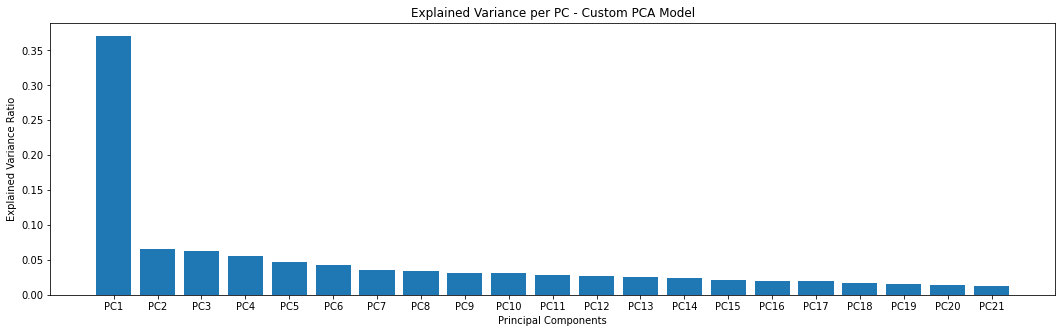

In [18]:
f, ax = plt.subplots(figsize=(18,5))
plt.bar(['PC'+str(i) for i in range(1,22)],pca_custom.explained_variance_ratio())
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance per PC - Custom PCA Model')
plt.show()



In [19]:
#import scikit-learn PCA
from sklearn.decomposition import PCA

#fit the PCA model and transform the data
pca    = PCA()
pcs    = pca.fit_transform(closes)
dfPCs2 = pd.DataFrame(pcs,columns=['PC'+str(i) for i in range(1,dfClose.shape[1]+1)])

In [22]:
dfClose.shape[1]+1

22

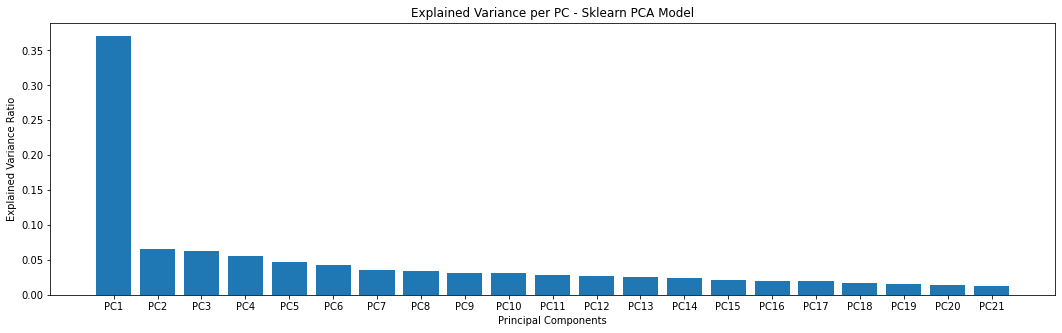

In [23]:
#how much variance is explained by each pc?
f, ax = plt.subplots(figsize=(18,5))
plt.bar(['PC'+str(i) for i in range(1,22)],pca.explained_variance_ratio_)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance per PC - Sklearn PCA Model')
plt.show()

In [24]:
#check if our two outputs are equal?
np.allclose(dfPCs1,dfPCs2)

False

In [25]:
#... ok what if we just compare the absolute values?
np.allclose(np.absolute(dfPCs1),np.absolute(dfPCs2))

True

In [26]:
#extract out our eigenvectors from the trained model
dfLoadings = pd.DataFrame(pca.components_,columns=dfClose.columns,index=dfPCs2.columns)

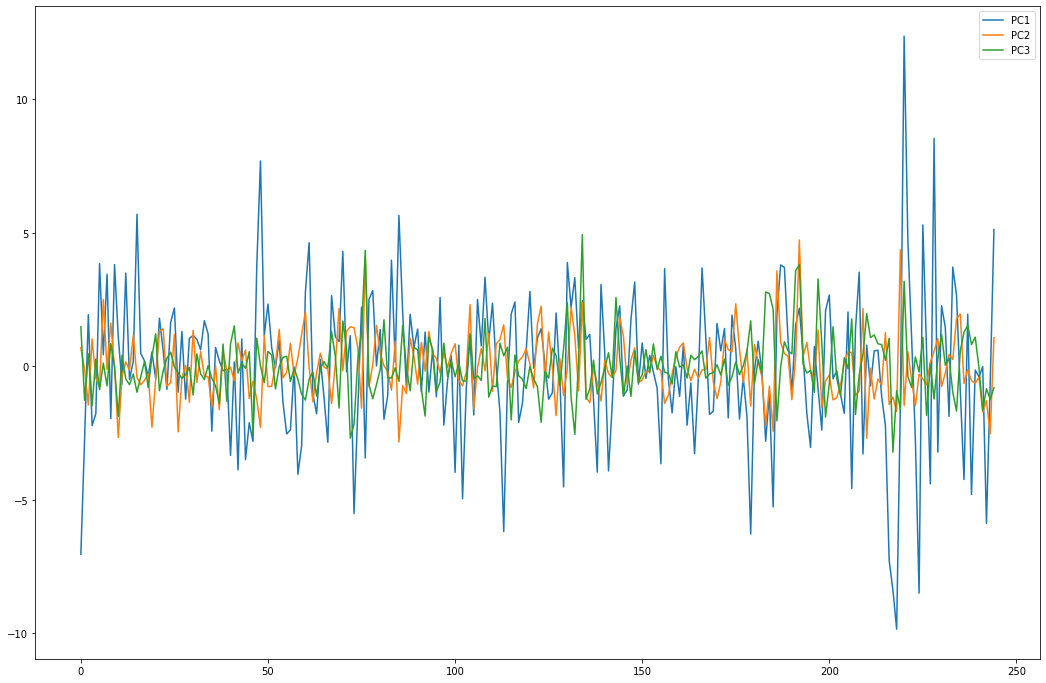

In [27]:
#plot just the first 3 PCs
dfPCs2[['PC1','PC2','PC3']].plot(figsize=(18,12))
plt.show()

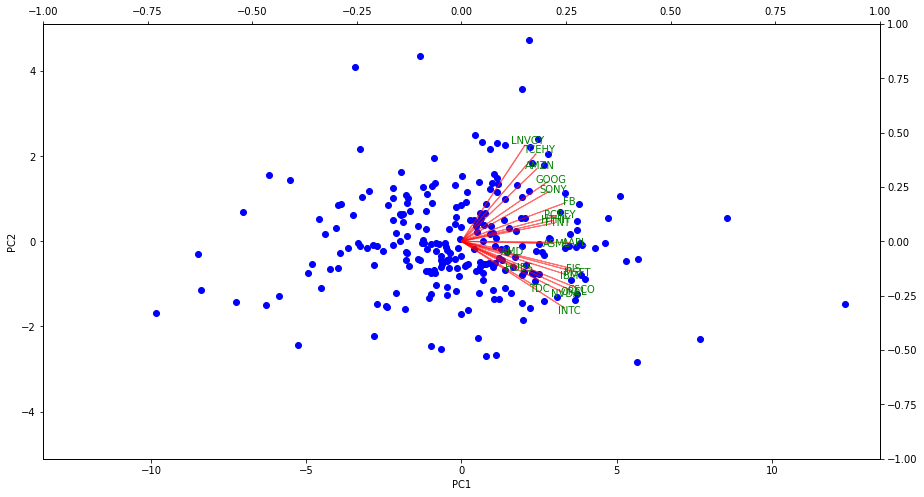

In [28]:
#produce biplot
biplot(dfPCs2, dfLoadings)